In [1]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'c01a4630-cc02-4828-9991-41259d9cb1a4'
resource_group = 'bot-resource-group'
workspace_name = 'MindNotesAnalysis'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='UserDetails')
df = dataset.to_pandas_dataframe()

In [2]:
import json

jsonData = json.loads(df["AppState"][1])

selfDiscoveryDf = jsonData["selfDiscoveryState"]


In [3]:
selfDiscoveryDf

{'showBackButtonModal': False,
 'showIntro': False,
 'level1': {'isLocked': False,
  'responses': {'1': {'answer': 'more than a year', 'prev': None, 'next': 2},
   '2': {'answer': 'rarely', 'prev': 1, 'next': 3},
   '3': {'answer': 'very often', 'prev': 2, 'next': 4},
   '4': {'answer': 'not confident at all', 'prev': 3, 'next': None}},
  'progressValue': 100},
 'level2': {'isLocked': False,
  'responses': {'DiscoveringEmotionResponse': {'quid1': {'answer': {'quid1': {'2': True}},
     'next': 'quid2',
     'prev': None},
    'quid2': {'answer': {'quid2': {'3': True, '4': False}},
     'next': 'quid1',
     'prev': 'quid2'}},
   'VignetteSectionResponse': {'quid4': {'answer': 'very similar',
     'next': 'quid1'},
    'quid1': {'answer': 'very similar', 'next': 'quid2', 'prev': 'quid4'},
    'quid2': {'answer': 'very similar', 'next': 'quid3', 'prev': 'quid1'},
    'quid3': {'answer': 'very similar', 'next': 'quid5', 'prev': 'quid2'},
    'quid5': {'answer': 'very similar', 'prev': 'qu

In [4]:
import enum

class LevelNumber(enum.Enum):
    level1 = "level1"
    level2 = "level2"
    level3 = "level3"
  
def checkLevelLockStatus(levelName, selfDiscoveryDf):
    return selfDiscoveryDf[levelName]["isLocked"]

def checkLevelProgressStatus(levelName, selfDiscoveryDf):
    return selfDiscoveryDf[levelName]["progressValue"]


# Seperate if else conditions added since later each code block would be customized per level
def checkSCResponses(levelType, selfDiscoveryDf):
    if(levelType == LevelNumber.level1):
        respDict = selfDiscoveryDf["level1"]["responses"]
        resp = {}
        for ke in respDict.keys():
            key_resp = "Q"+ "_" + ke
            resp[key_resp] = respDict[ke]["answer"]
        return resp
    elif(levelType == LevelNumber.level2):
        respDict = selfDiscoveryDf["level2"]["responses"]
        resp = {}
        questionList = ["timeOfRecording", "Think of a recent situation when you were critical towards yourself. Write down your self critical thoughts", "ACT1:Mindfulness", "ACT2:Common humanity", "ACT3:Kindness"]
        for ke in respDict.keys():
            key_resp = "Q"+ "_" + ke
            localResp = {}
            for item in range(len(questionList)):
                localResp[questionList[item]] =  respDict[ke]["answer"][item]
            resp[key_resp] = localResp
        return resp
    else:
        respDict = selfDiscoveryDf["level3"]["responses"]
        resp = {}
        questionList = ["timeOfRecording", "Think of and describe about a current struggle.","Express:Mindfulness", "Express:Common humanity", "Express:Kindness"]

        for ke in respDict.keys():
            key_resp = "Q"+ "_" + ke
            localResp = {}
            for item in range(len(questionList)):
                localResp[questionList[item]] =  respDict[ke]["answer"][item]
            resp[key_resp] = localResp      
        return resp




In [5]:
checkLevelProgressStatus("level3", selfDiscoveryDf)

100

In [6]:
checkSCResponses(LevelNumber.level1, selfDiscoveryDf)

{'Q_1': 'more than a year',
 'Q_2': 'rarely',
 'Q_3': 'very often',
 'Q_4': 'not confident at all'}

In [7]:
selfDiscoveryDf["level3"]["homeState"]

{'homeTypeChosen': 'type3',
 'lowCard': {'locked': False, 'completed': True},
 'anxiousCard': {'locked': False, 'completed': True},
 'result': {'completed': False, 'locked': False},
 'functioningCard': {'locked': False, 'completed': True}}

In [8]:
def checkSelfDiscoveryHomeState(selfDiscoveryDf):
    typeChosen = selfDiscoveryDf["level3"]["homeState"]["homeTypeChosen"]
    return typeChosen

In [9]:
def iterateForAllUsers():
    total = df["AppState"].size
    userMapping = {}
    for user in range(total):
        jsonData = json.loads(df["AppState"][user])
        selfDiscoveryDf = jsonData["selfDiscoveryState"]
        userMapping[df["UserId"][user]] = checkSelfDiscoveryHomeState(selfDiscoveryDf)
    return userMapping

def checkLevel1ResponsesForAll():
    total = df["AppState"].size
    userMapping = {}
    for user in range(total):
        jsonData = json.loads(df["AppState"][user])
        selfDiscoveryDf = jsonData["selfDiscoveryState"]
        userMapping[df["UserId"][user]] = checkSCResponses(LevelNumber.level1, selfDiscoveryDf)
    return userMapping




In [10]:
userMapping = iterateForAllUsers()

## Plotting Level 3 Self Discovery 
Plotting the number of Users who chose Type2/Type3/Type1 or didnt visit SelfDiscovery Level3 at all

In [11]:
def checkCountType(typeHome,userMapping):
    count =0
    for k in userMapping.keys():
        if(userMapping[k] == typeHome):
            count += 1
    return count


In [12]:
checkCountType('type2', userMapping)

2

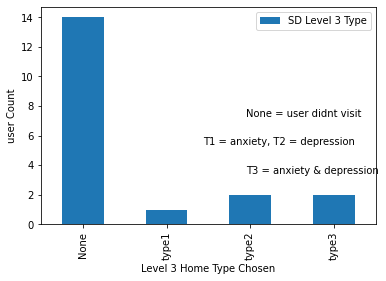

In [13]:
# SD Level 3 Check which Type chosen
import matplotlib.pyplot as plt
import pandas as pd
homeTypes = [None, 'type1', 'type2', 'type3']
plotdata = pd.DataFrame(
    {"SD Level 3 Type": [checkCountType(typeHome, userMapping) for typeHome in homeTypes]}, 
    index=homeTypes)
# Plot a bar chart
plotdata.plot(kind="bar")
plt.xlabel("Level 3 Home Type Chosen")
plt.ylabel("user Count")
plt.figtext(.6, .5, "None = user didnt visit") 
plt.figtext(.5,.4, "T1 = anxiety, T2 = depression") 
plt.figtext(.6, .3, "T3 = anxiety & depression")
plt.savefig('./Plots/SelfDiscovery/SDLevel3Type.png')

In [14]:
selfDiscoveryDf["level1"]

{'isLocked': False,
 'responses': {'1': {'answer': 'more than a year', 'prev': None, 'next': 2},
  '2': {'answer': 'rarely', 'prev': 1, 'next': 3},
  '3': {'answer': 'very often', 'prev': 2, 'next': 4},
  '4': {'answer': 'not confident at all', 'prev': 3, 'next': None}},
 'progressValue': 100}

In [15]:
checkSCResponses(LevelNumber.level1, selfDiscoveryDf)

{'Q_1': 'more than a year',
 'Q_2': 'rarely',
 'Q_3': 'very often',
 'Q_4': 'not confident at all'}

In [16]:
checkLevel1ResponsesForAll()


{'5704b8c3-0e67-4127-4d78-08d8cc33525c': {'Q_1': 'a week',
  'Q_2': 'rarely',
  'Q_3': 'rarely',
  'Q_4': 'not confident at all'},
 'b93d2a00-fe4a-4b0f-4d7a-08d8cc33525c': {'Q_1': 'more than a year',
  'Q_2': 'rarely',
  'Q_3': 'very often',
  'Q_4': 'not confident at all'},
 'b6a54ac9-3268-4ecb-4d7b-08d8cc33525c': {},
 '4d65f14e-74b2-4077-4d7e-08d8cc33525c': {'Q_1': 'more than a year',
  'Q_2': 'often',
  'Q_3': 'sometimes',
  'Q_4': 'very confident'},
 '46557658-06af-4808-4d7f-08d8cc33525c': {'Q_1': 'a year',
  'Q_2': 'rarely',
  'Q_3': 'often',
  'Q_4': 'slightly confident'},
 'c1f1cfbb-28b0-4788-4d80-08d8cc33525c': {'Q_1': 'a week',
  'Q_2': 'very often',
  'Q_3': 'rarely',
  'Q_4': 'very confident'},
 'adeb096a-0090-4191-4d81-08d8cc33525c': {'Q_1': 'a year',
  'Q_2': 'often',
  'Q_3': 'very often',
  'Q_4': 'fairly confident'},
 '17cb7b35-4653-4c2f-4d82-08d8cc33525c': {},
 '8ab775d5-6848-4687-4d83-08d8cc33525c': {},
 'f1031320-6c06-41bb-4d86-08d8cc33525c': {},
 '560fce02-1819-4493

Check the association strength between a particular SD L1 Question and its response.

Check for one-hot encoding

https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/

One-hot encoding for the responses can be done.

# Creating a Dataframe


In [17]:
selfDiscoveryDf

{'showBackButtonModal': False,
 'showIntro': False,
 'level1': {'isLocked': False,
  'responses': {'1': {'answer': 'more than a year', 'prev': None, 'next': 2},
   '2': {'answer': 'rarely', 'prev': 1, 'next': 3},
   '3': {'answer': 'very often', 'prev': 2, 'next': 4},
   '4': {'answer': 'not confident at all', 'prev': 3, 'next': None}},
  'progressValue': 100},
 'level2': {'isLocked': False,
  'responses': {'DiscoveringEmotionResponse': {'quid1': {'answer': {'quid1': {'2': True}},
     'next': 'quid2',
     'prev': None},
    'quid2': {'answer': {'quid2': {'3': True, '4': False}},
     'next': 'quid1',
     'prev': 'quid2'}},
   'VignetteSectionResponse': {'quid4': {'answer': 'very similar',
     'next': 'quid1'},
    'quid1': {'answer': 'very similar', 'next': 'quid2', 'prev': 'quid4'},
    'quid2': {'answer': 'very similar', 'next': 'quid3', 'prev': 'quid1'},
    'quid3': {'answer': 'very similar', 'next': 'quid5', 'prev': 'quid2'},
    'quid5': {'answer': 'very similar', 'prev': 'qu

In [21]:
pd.DataFrame({"SD Level 1 Progress":[], "SD Level 2 Progress":[], "SD Level 3 Progress": [], "Level 1 Q1 Responses":[], "Level 1 Q2 Responses": [],"Level 1 Q3 Responses" :[], "Level 1 Q4 Responses":[], "Level 2 Discovering Emotion Q1":[], "Level 2 Discovering Emotion Q2":[], "Vignette 1":[], "Vignette 2":[], "Vignette 3":[], "Vignette 4":[], "Vignette 5":[], "Level 3 Home Type Chosen":[], "PHQ Score":[], "GAD Score":[], "WSAS Score":[]})

,SD Level 1 Progress,SD Level 2 Progress,SD Level 3 Progress,Level 1 Q1 Responses,Level 1 Q2 Responses,Level 1 Q3 Responses,Level 1 Q4 Responses,Level 2 Discovering Emotion Q1,Level 2 Discovering Emotion Q2,Vignette 1,Vignette 2,Vignette 3,Vignette 4,Vignette 5,Level 3 Home Type Chosen,PHQ Score,GAD Score,WSAS Score
